## Imports and Random Seed

In [1]:
import os, random, numpy as np, torch

SEED = 42
# 1️⃣  Pure‑Python & NumPy
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# 2️⃣  Threading / BLAS
os.environ["OMP_NUM_THREADS"]  = "1"   # OpenMP
os.environ["MKL_NUM_THREADS"]  = "1"   # MKL / NumPy
torch.set_num_threads(1)
torch.set_num_interop_threads(1)

torch.set_deterministic_debug_mode(True)


# 3️⃣  CUDA (skip if you stay on CPU), *before* importing torch.cuda
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"   # or ":4096:8" for big convs

# 4️⃣  PyTorch itself
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)           # safe even if CUDA not present
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False
torch.use_deterministic_algorithms(True)   # 🔒 raise on nondet ops


In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# PyTorch and related imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# For splitting and metrics
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error



In [3]:
import random; import numpy as np; import torch
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



#### 1) Load CSV and stratified split data



In [4]:
CSV_PATH = '../../../data-prep/MOS.csv'
IMG_DIR = '../../../static'


In [5]:
df = pd.read_csv(CSV_PATH)

# Create bins for stratification
n_bins = 10  # You can adjust this number
df['MOS_bin'] = pd.qcut(df['MOS'], n_bins, labels=False)



assert 'filename' in df.columns, f"Expected 'filename' column, got {df.columns}"
assert 'MOS'      in df.columns, f"Expected 'MOS' column, got {df.columns}"
assert not df[['filename','MOS']].isnull().any().any(), "Found NaNs in filenames or MOS"
dupes = df['filename'][df['filename'].duplicated()]
assert dupes.empty, f"Duplicate filenames: {dupes.tolist()}"

df.head()


,filename,MOS,MOS_bin
0,f1.png,47.058940,1
1,f10.png,59.343239,2
2,f100.png,67.845299,4
3,f101.png,66.061042,4
4,f102.png,55.699696,2


In [6]:
# Stratified split
train_df, temp_df = train_test_split(df, test_size=0.30, random_state=SEED, stratify=df['MOS_bin'])
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=SEED, stratify=temp_df['MOS_bin'])

# Drop the bin column as it's no longer needed
train_df = train_df.drop(columns=['MOS_bin'])
val_df = val_df.drop(columns=['MOS_bin'])
test_df = test_df.drop(columns=['MOS_bin'])


In [7]:
# Stratified split sanity (Disjoint splits)
train_ids = set(train_df.index)
val_ids   = set(val_df.index)
test_ids  = set(test_df.index)
assert train_ids.isdisjoint(val_ids) and train_ids.isdisjoint(test_ids) and val_ids.isdisjoint(test_ids), "Overlap between splits!"


# Compute mean & std on the TRAIN set only
mos_mean = train_df['MOS'].mean()
mos_std  = train_df['MOS'].std()

# Apply z-score normalization to all three splits
for df_split in (train_df, val_df, test_df):
    df_split['MOS'] = (df_split['MOS'] - mos_mean) / mos_std



#### Visualize MOS Score Distribution Across Splits




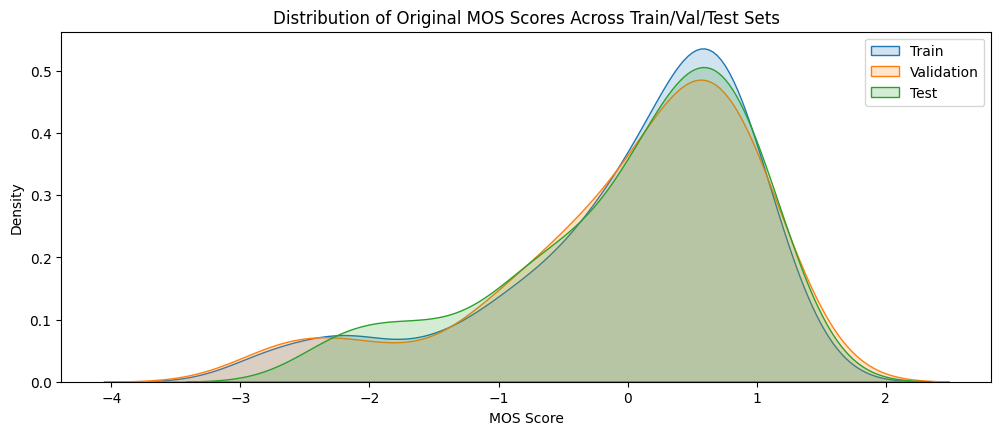

In [8]:
import seaborn as sns


plt.figure(figsize=(12, 10))

# Original MOS distributions (before normalization)
plt.subplot(2, 1, 1)
sns.kdeplot(train_df['MOS'], label='Train', fill=True, alpha=0.2)
sns.kdeplot(val_df['MOS'], label='Validation', fill=True, alpha=0.2)
sns.kdeplot(test_df['MOS'], label='Test', fill=True, alpha=0.2)
plt.title('Distribution of Original MOS Scores Across Train/Val/Test Sets')
plt.xlabel('MOS Score')
plt.ylabel('Density')
plt.legend()


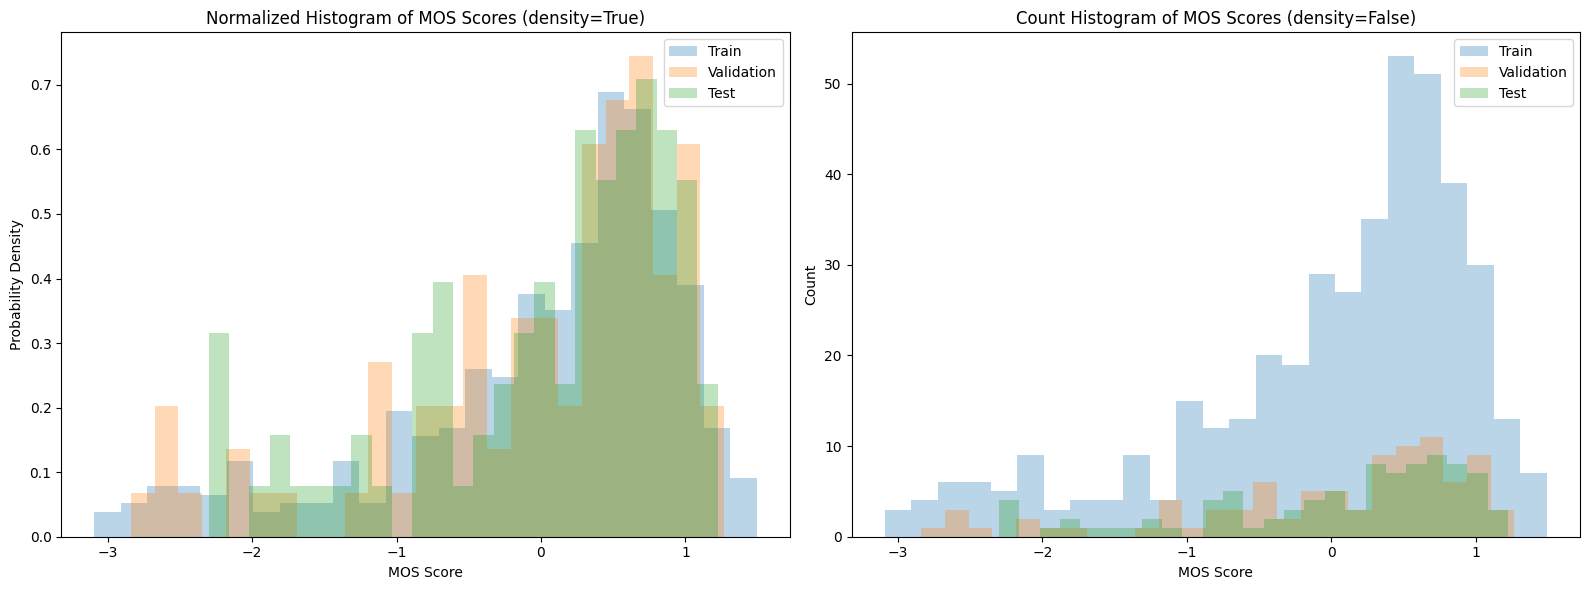

In [9]:
# Create histograms to better see the actual distributions
plt.figure(figsize=(16, 6))

# Left subplot with density=True (normalized)
plt.subplot(1, 2, 1)
plt.hist(train_df['MOS'], bins=25, alpha=0.3, label='Train', density=True)
plt.hist(val_df['MOS'], bins=25, alpha=0.3, label='Validation', density=True)
plt.hist(test_df['MOS'], bins=25, alpha=0.3, label='Test', density=True)
plt.title('Normalized Histogram of MOS Scores (density=True)')
plt.xlabel('MOS Score')
plt.ylabel('Probability Density')
plt.legend()

# Right subplot with density=False (count)
plt.subplot(1, 2, 2)
plt.hist(train_df['MOS'], bins=25, alpha=0.3, label='Train', density=False)
plt.hist(val_df['MOS'], bins=25, alpha=0.3, label='Validation', density=False)
plt.hist(test_df['MOS'], bins=25, alpha=0.3, label='Test', density=False)
plt.title('Count Histogram of MOS Scores (density=False)')
plt.xlabel('MOS Score')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()


Statistics for MOS (z-normalized)


,Split,Count,Mean,Std,Min,25%,Median,75%,Max
0,Train,420,0.0000,1.0000,-3.0909,-0.4237,0.2976,0.7205,1.4920
1,Validation,90,-0.0031,1.0015,-2.8380,-0.4127,0.3143,0.7185,1.2678
2,Test,90,0.0346,0.9219,-2.2998,-0.5278,0.2782,0.7092,1.2234


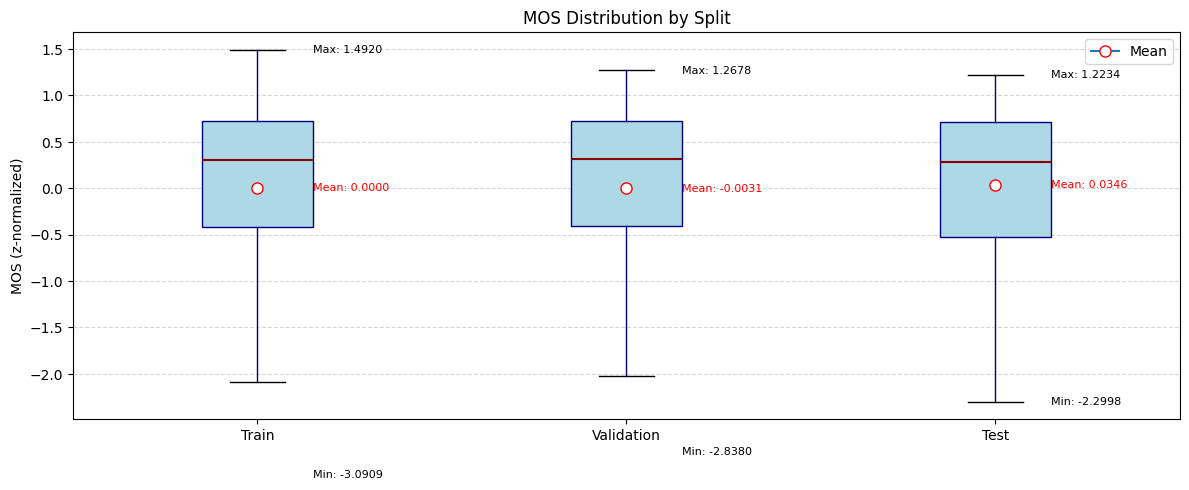

In [10]:
# Create summary statistics for each split
split_dfs = {
    'Train': train_df,
    'Validation': val_df, 
    'Test': test_df
}

# Make sure we're using the same column ('MOS') for everything
mos_column = 'MOS'

# Generate statistics
stats_df = pd.DataFrame({
    'Split': split_dfs.keys(),
    'Count': [df.shape[0] for df in split_dfs.values()],
    'Mean': [df[mos_column].mean() for df in split_dfs.values()],
    'Std': [df[mos_column].std() for df in split_dfs.values()],
    'Min': [df[mos_column].min() for df in split_dfs.values()],
    '25%': [df[mos_column].quantile(0.25) for df in split_dfs.values()],
    'Median': [df[mos_column].median() for df in split_dfs.values()],
    '75%': [df[mos_column].quantile(0.75) for df in split_dfs.values()],
    'Max': [df[mos_column].max() for df in split_dfs.values()]
})

# Display styled statistics table
print("Statistics for MOS (z-normalized)")
display(stats_df.style.background_gradient(cmap='Blues', subset=['Mean', 'Std', 'Min', 'Max'])
        .format(precision=4)
        .set_caption('MOS Statistics Across Data Splits (z-normalized)'))

# Create visualizations in a single figure
fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))

# Box plot - explicitly using the same data as in the statistics
mos_data = [df[mos_column] for df in split_dfs.values()]

# Add annotations to the boxplot for verification
bp = ax1.boxplot(mos_data,
           tick_labels=split_dfs.keys(),
           showfliers=False,
           patch_artist=True,
           boxprops=dict(facecolor='lightblue', color='navy'),
           whiskerprops=dict(color='navy'),
           medianprops=dict(color='darkred', linewidth=1.5))

# Add mean markers to boxplot
for i, data in enumerate(mos_data):
    mean = data.mean()
    ax1.plot(i+1, mean, marker='o', markerfacecolor='white', markeredgecolor='red', 
             markersize=8, label='Mean' if i==0 else "")

ax1.set_ylabel('MOS (z-normalized)')
ax1.set_title('MOS Distribution by Split')
ax1.grid(axis='y', linestyle='--', alpha=0.5)
ax1.legend()

# Add text annotations for min, mean, median, max
for i, data in enumerate(mos_data):
    min_val = data.min()
    max_val = data.max()
    mean_val = data.mean()
    median_val = data.median()
    
    # Add text annotations slightly offset from the plot
    ax1.text(i+1.15, min_val, f'Min: {min_val:.4f}', fontsize=8, ha='left', va='center')
    ax1.text(i+1.15, max_val, f'Max: {max_val:.4f}', fontsize=8, ha='left', va='center')
    ax1.text(i+1.15, mean_val, f'Mean: {mean_val:.4f}', fontsize=8, ha='left', va='center', color='red')

plt.tight_layout()
plt.show()


In [11]:
from IPython.display import display_html, HTML

# Get the shapes
train_shape = train_df.shape
val_shape = val_df.shape
test_shape = test_df.shape

# Function to convert dataframe to styled HTML with shape info
def df_to_html_with_shape(df, title, shape):
    shape_str = f"Shape: {shape[0]} rows × {shape[1]} columns"
    styled_html = f"""
    <div style="margin-right: 10px; display: inline-block; vertical-align: top; width: 31%;">
        <h3 style="text-align: center; color: #0066cc;">{title}</h3>
        <p style="text-align: center; font-style: italic; margin-bottom: 5px;">{shape_str}</p>
        {df.head(4).style.set_table_attributes('class="dataframe" style="width: 100%;"').to_html()}
    </div>
    """
    return styled_html

# Combine all three HTML tables
all_tables_html = df_to_html_with_shape(train_df, "Training Data", train_shape) + \
                 df_to_html_with_shape(val_df, "Validation Data", val_shape) + \
                 df_to_html_with_shape(test_df, "Test Data", test_shape)

# Create a container
container_html = f"""
<div style="display: flex; justify-content: space-between; width: 100%;">
    {all_tables_html}
</div>
"""

# Display the HTML
display_html(HTML(container_html))


,filename,MOS
255,f329.png,0.134646
241,f316.png,-0.954147
175,f257.png,0.978417
119,f206.png,-3.041686
,filename,MOS
445,f68.png,-0.149500
102,f191.png,-0.241829
198,f278.png,0.154798
439,f62.png,0.469404
,filename,MOS


Total: 600 rows (because we have 600 images)



#### 3) Create a PyTorch Dataset and DataLoader



In [12]:
# Set image dimensions
HEIGHT, WIDTH = 384, 512

# Define transforms for training and evaluation
train_transforms = transforms.Compose([
    # Data augmentation (random horizontal and vertical flip)
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(degrees=10), # Random rotation (±10 degrees)

    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),  # small rotations
    transforms.RandomResizedCrop(size=(384, 512), scale=(0.9, 1.0), ratio=(1.25, 1.35)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # light changes

    transforms.ToTensor(), # Convert image to tensor and scale pixel values to [0,1]
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# For validation and testing we only need to convert to tensor.
eval_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


# Simpler transform: only ToTensor + Normalize
simple_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])




In [13]:
class ImageMOSDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame with columns 'filename' and 'MOS'
            img_dir (str): Directory with all the images.
            transform: torchvision transforms to apply to images.
        """

        missing = [f for f in dataframe['filename'] if not os.path.isfile(os.path.join(img_dir, f))]
        assert not missing, f"Missing image files: {missing[:5]}…"

        self.dataframe = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get the image filename and full path
        filename = self.dataframe.loc[idx, 'filename']
        img_path = os.path.join(self.img_dir, filename)
        # Open image and ensure it is RGB
        image = Image.open(img_path).convert("RGB")

        
        if self.transform:
            image = self.transform(image)
        

        # Get the normalized MOS value as a float tensor
        mos = torch.tensor(self.dataframe.loc[idx, 'MOS'], dtype=torch.float32)

        assert isinstance(image, torch.Tensor)
        assert image.shape == (3, HEIGHT, WIDTH), f"Got shape {image.shape}"
        assert  torch.isfinite(mos), "MOS is not finite"


        return image, mos



In [14]:
train_dataset = ImageMOSDataset(train_df, IMG_DIR, transform=train_transforms)
val_dataset   = ImageMOSDataset(val_df,   IMG_DIR, transform=eval_transforms)
test_dataset  = ImageMOSDataset(test_df,  IMG_DIR, transform=eval_transforms)

# Print the number of images in each dataset
print(f"Number of images in training dataset: {len(train_dataset)}")
print(f"Number of images in validation dataset: {len(val_dataset)}")
print(f"Number of images in test dataset: {len(test_dataset)}")



Number of images in training dataset: 420
Number of images in validation dataset: 90
Number of images in test dataset: 90


In [15]:
BATCH_SIZE = 32 # Create DataLoaders


g = torch.Generator().manual_seed(SEED)

def worker_init_fn(worker_id):
    # guarantees that each DataLoader worker reproduces its own stream
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    torch.manual_seed(worker_seed)



# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, generator=g)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,          
    generator=g,
    worker_init_fn=worker_init_fn  # Change from None to worker_init_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,          
    generator=g,
    worker_init_fn=worker_init_fn  # Change from None to worker_init_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,          
    generator=g,
    worker_init_fn=worker_init_fn  # Change from None to worker_init_fn
)

# val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, generator=g)
# test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, generator=g)


In [16]:
first_batch = next(iter(train_loader))
print("First batch sample MOS values:", first_batch[1][:5].tolist())


First batch sample MOS values: [-0.7934278845787048, 0.8394438624382019, -0.19277027249336243, 0.03462066873908043, 1.1148629188537598]


In [17]:
imgs, moss = next(iter(train_loader))
# check batch dims/types
assert imgs.ndim == 4 and imgs.shape[1:] == (3,HEIGHT,WIDTH)
assert moss.ndim == 1 and moss.dtype == torch.float32



In [18]:
# imgs.shape, moss.shape


There is only one image when we iterate through the train_dataset


In [19]:
for i in range(10):
    img, mos = train_dataset[i]
    print(img.shape, mos.item())


torch.Size([3, 384, 512]) 0.13464580476284027
torch.Size([3, 384, 512]) -0.954147458076477
torch.Size([3, 384, 512]) 0.978416919708252
torch.Size([3, 384, 512]) -3.0416858196258545
torch.Size([3, 384, 512]) -0.19277027249336243
torch.Size([3, 384, 512]) -0.411110520362854
torch.Size([3, 384, 512]) 0.9699268937110901
torch.Size([3, 384, 512]) 0.48901858925819397
torch.Size([3, 384, 512]) 1.2568248510360718
torch.Size([3, 384, 512]) 0.35381844639778137


There are 32 images in one batch of the train_loader


In [20]:
for img, mos in train_loader:
    print(img.shape, mos.shape)
    j=0
    for i, mos_ in zip(img, mos):
        print(f"-== --== -\nCOUNT{j}\n-----")
        print(f"Image shape: {i.shape}\nMOS: {mos_}")
        j+=1
    break


torch.Size([32, 3, 384, 512]) torch.Size([32])
-== --== -
COUNT0
-----
Image shape: torch.Size([3, 384, 512])
MOS: 0.9462814927101135
-== --== -
COUNT1
-----
Image shape: torch.Size([3, 384, 512])
MOS: 0.7497540712356567
-== --== -
COUNT2
-----
Image shape: torch.Size([3, 384, 512])
MOS: 0.07069732993841171
-== --== -
COUNT3
-----
Image shape: torch.Size([3, 384, 512])
MOS: -0.4717830419540405
-== --== -
COUNT4
-----
Image shape: torch.Size([3, 384, 512])
MOS: -0.08805374801158905
-== --== -
COUNT5
-----
Image shape: torch.Size([3, 384, 512])
MOS: -0.07966345548629761
-== --== -
COUNT6
-----
Image shape: torch.Size([3, 384, 512])
MOS: 1.0192173719406128
-== --== -
COUNT7
-----
Image shape: torch.Size([3, 384, 512])
MOS: 0.961453378200531
-== --== -
COUNT8
-----
Image shape: torch.Size([3, 384, 512])
MOS: 0.39313140511512756
-== --== -
COUNT9
-----
Image shape: torch.Size([3, 384, 512])
MOS: 0.3120872378349304
-== --== -
COUNT10
-----
Image shape: torch.Size([3, 384, 512])
MOS: 0.047562

#### 4) Create the Model




In [21]:
class SimpleCNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(SimpleCNN, self).__init__()

        # First convolutional block
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)  # (384x512 → 192x256)
        )

        # Second convolutional block
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)  # → 96x128
        )

        # Third convolutional block
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)  # → 48x64
        )

        # Fourth convolutional block
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)  # → 24x32
        )
        
        # Fifth convolutional block (added)
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)  # → 12x16
        )

        # Global average pooling instead of flattening
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # Output: 256x1x1
        
        # Fully connected layers
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        
        # Global average pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 256)
        
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x


if torch.backends.mps.is_available():
    torch.mps.manual_seed(SEED)

# Instantiate the model and send to device (GPU if available)
device = torch.device("mps" if torch.mps.is_available() else "cpu")
# device = torch.device("cpu")

print(device)
model = SimpleCNN().to(device)
print(model)


mps
SimpleCNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), paddin

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"Total number of trainable parameters: {num_params:,}")


Total number of trainable parameters: 434,817


### Training loop


In [23]:
# Define multiple loss functions
loss_functions = {
    'mse': nn.MSELoss(),
    'mae': nn.L1Loss(),
    'huber': nn.SmoothL1Loss(),  # Combination of L1 and L2 loss
}

# Function to compute SROCC loss (negative Spearman correlation)
def srocc_loss(pred, target):
    # Convert tensors to cpu and numpy
    pred_np = pred.detach().cpu().numpy().flatten()
    target_np = target.detach().cpu().numpy().flatten()
    
    # Compute Spearman correlation coefficient
    srocc = spearmanr(pred_np, target_np)[0]
    
    # Return negative correlation as loss (higher correlation = lower loss)
    # Handle NaN values that can occur with constant predictions
    if np.isnan(srocc):
        return torch.tensor(1.0, device=pred.device, requires_grad=True)
    return torch.tensor(1.0 - srocc, device=pred.device, requires_grad=True)

# Add custom SROCC loss to dictionary
loss_functions['srocc'] = srocc_loss

# Function to train model with specified loss functions
def train_model(model, train_loader, val_loader, loss_fns, optimizer, epochs=75, device='cpu'):
    # Initialize tracking variables
    train_losses = {name: [] for name in loss_fns.keys()}
    val_losses = {name: [] for name in loss_fns.keys()}
    
    # Use first loss function as primary training objective
    primary_loss_name = list(loss_fns.keys())[0]
    primary_loss_fn = loss_fns[primary_loss_name]
    
    # Best model tracking
    best_val_loss = float('inf')
    best_model_weights = None
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_batch_losses = {name: 0.0 for name in loss_fns.keys()}
        num_samples = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)  # ensure labels are (batch, 1)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            # Compute primary loss for backpropagation
            loss = primary_loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Record batch size
            batch_size = images.size(0)
            num_samples += batch_size
            
            # Compute and store all losses for monitoring
            for name, loss_fn in loss_fns.items():
                if name == primary_loss_name:
                    # Already computed this loss
                    batch_loss = loss.item() * batch_size
                else:
                    # Compute other losses for monitoring only
                    with torch.no_grad():
                        batch_loss = loss_fn(outputs, labels).item() * batch_size
                        
                        # Special handling for SROCC which isn't averaged by batch size
                        if name == 'srocc':
                            batch_loss = loss_fn(outputs, labels).item()
                
                train_batch_losses[name] += batch_loss
        
        # Compute epoch losses
        for name in loss_fns.keys():
            if name == 'srocc':
                # SROCC loss isn't averaged by batch size
                epoch_loss = train_batch_losses[name]
            else:
                epoch_loss = train_batch_losses[name] / num_samples
            train_losses[name].append(epoch_loss)
        
        # Validation phase
        model.eval()
        val_batch_losses = {name: 0.0 for name in loss_fns.keys()}
        num_val_samples = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device).unsqueeze(1)
                outputs = model(images)
                
                batch_size = images.size(0)
                num_val_samples += batch_size
                
                # Compute all validation losses
                for name, loss_fn in loss_fns.items():
                    batch_loss = loss_fn(outputs, labels).item()
                    
                    # Special handling for SROCC which isn't averaged by batch size
                    if name != 'srocc':
                        batch_loss *= batch_size
                    
                    val_batch_losses[name] += batch_loss
        
        # Compute validation epoch losses
        for name in loss_fns.keys():
            if name == 'srocc':
                # SROCC loss isn't averaged by batch size
                val_epoch_loss = val_batch_losses[name]
            else:
                val_epoch_loss = val_batch_losses[name] / num_val_samples
            val_losses[name].append(val_epoch_loss)
        
        # Print progress
        log_str = f"Epoch {epoch+1}/{epochs}"
        for name in loss_fns.keys():
            log_str += f"  Train {name}: {train_losses[name][-1]:.4f}  Val {name}: {val_losses[name][-1]:.4f}"
        print(log_str)
        
        # Save best model (using primary loss)
        val_primary_loss = val_losses[primary_loss_name][-1]
        if val_primary_loss < best_val_loss:
            best_val_loss = val_primary_loss
            best_model_weights = model.state_dict().copy()
    
    # Load best model weights
    if best_model_weights:
        model.load_state_dict(best_model_weights)
    
    return model, train_losses, val_losses


In [24]:
# Define which loss functions to use
selected_losses = {
    'mse': loss_functions['mse'],   # Primary loss for training
    'mae': loss_functions['mae'],   # Monitor MAE
    'huber': loss_functions['huber'] # Monitor Huber loss
}

# Train model
EPOCHS = 75
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
optimizer = optim.Adam(model.parameters(), lr=1e-4, eps=1e-8, weight_decay=0)
model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, 
    selected_losses, optimizer, EPOCHS, device
)


Epoch 1/75  Train mse: 1.0007  Val mse: 1.0096  Train mae: 0.7592  Val mae: 0.7566  Train huber: 0.3933  Val huber: 0.3892


Epoch 2/75  Train mse: 0.9662  Val mse: 1.0129  Train mae: 0.7569  Val mae: 0.7493  Train huber: 0.3879  Val huber: 0.3867


Epoch 3/75  Train mse: 0.9123  Val mse: 0.9186  Train mae: 0.7420  Val mae: 0.7296  Train huber: 0.3723  Val huber: 0.3676


Epoch 4/75  Train mse: 0.8821  Val mse: 0.8785  Train mae: 0.7415  Val mae: 0.7294  Train huber: 0.3711  Val huber: 0.3663


Epoch 5/75  Train mse: 0.8421  Val mse: 0.8262  Train mae: 0.7232  Val mae: 0.6673  Train huber: 0.3581  Val huber: 0.3332


Epoch 6/75  Train mse: 0.8237  Val mse: 0.8155  Train mae: 0.7015  Val mae: 0.7018  Train huber: 0.3480  Val huber: 0.3459


Epoch 7/75  Train mse: 0.8232  Val mse: 0.8182  Train mae: 0.7073  Val mae: 0.6600  Train huber: 0.3475  Val huber: 0.3323


Epoch 8/75  Train mse: 0.7965  Val mse: 0.8048  Train mae: 0.6786  Val mae: 0.6497  Train huber: 0.3352  Val huber: 0.3216


Epoch 9/75  Train mse: 0.8078  Val mse: 0.7784  Train mae: 0.6950  Val mae: 0.6613  Train huber: 0.3466  Val huber: 0.3215


Epoch 10/75  Train mse: 0.7363  Val mse: 0.8023  Train mae: 0.6612  Val mae: 0.6739  Train huber: 0.3183  Val huber: 0.3301


Epoch 11/75  Train mse: 0.7224  Val mse: 0.8747  Train mae: 0.6510  Val mae: 0.6480  Train huber: 0.3110  Val huber: 0.3327


Epoch 12/75  Train mse: 0.7646  Val mse: 0.7901  Train mae: 0.6524  Val mae: 0.6659  Train huber: 0.3199  Val huber: 0.3219


Epoch 13/75  Train mse: 0.7075  Val mse: 0.8394  Train mae: 0.6486  Val mae: 0.6839  Train huber: 0.3073  Val huber: 0.3402


Epoch 14/75  Train mse: 0.7010  Val mse: 0.8679  Train mae: 0.6501  Val mae: 0.6528  Train huber: 0.3065  Val huber: 0.3310


Epoch 15/75  Train mse: 0.6846  Val mse: 0.8771  Train mae: 0.6156  Val mae: 0.6752  Train huber: 0.2917  Val huber: 0.3422


Epoch 16/75  Train mse: 0.6854  Val mse: 0.7939  Train mae: 0.6311  Val mae: 0.6943  Train huber: 0.2955  Val huber: 0.3380


Epoch 17/75  Train mse: 0.6755  Val mse: 0.9385  Train mae: 0.6197  Val mae: 0.6681  Train huber: 0.2887  Val huber: 0.3492


Epoch 18/75  Train mse: 0.6944  Val mse: 0.8670  Train mae: 0.6251  Val mae: 0.6582  Train huber: 0.3000  Val huber: 0.3332


Epoch 19/75  Train mse: 0.7368  Val mse: 0.8412  Train mae: 0.6649  Val mae: 0.6528  Train huber: 0.3166  Val huber: 0.3263


Epoch 20/75  Train mse: 0.7160  Val mse: 0.8222  Train mae: 0.6455  Val mae: 0.7007  Train huber: 0.3073  Val huber: 0.3456


Epoch 21/75  Train mse: 0.6891  Val mse: 0.8078  Train mae: 0.6493  Val mae: 0.6315  Train huber: 0.3040  Val huber: 0.3160


Epoch 22/75  Train mse: 0.6943  Val mse: 0.8299  Train mae: 0.6526  Val mae: 0.6514  Train huber: 0.3065  Val huber: 0.3244


Epoch 23/75  Train mse: 0.7004  Val mse: 0.8260  Train mae: 0.6394  Val mae: 0.6597  Train huber: 0.3013  Val huber: 0.3258


Epoch 24/75  Train mse: 0.6362  Val mse: 0.7815  Train mae: 0.6179  Val mae: 0.6530  Train huber: 0.2834  Val huber: 0.3158


Epoch 25/75  Train mse: 0.6792  Val mse: 0.8892  Train mae: 0.6216  Val mae: 0.6476  Train huber: 0.2937  Val huber: 0.3343


Epoch 26/75  Train mse: 0.6348  Val mse: 0.9616  Train mae: 0.6124  Val mae: 0.6462  Train huber: 0.2771  Val huber: 0.3474


Epoch 27/75  Train mse: 0.6822  Val mse: 0.8716  Train mae: 0.6432  Val mae: 0.6609  Train huber: 0.3006  Val huber: 0.3353


Epoch 28/75  Train mse: 0.6212  Val mse: 0.8544  Train mae: 0.6071  Val mae: 0.7004  Train huber: 0.2740  Val huber: 0.3526


Epoch 29/75  Train mse: 0.6317  Val mse: 0.8378  Train mae: 0.6079  Val mae: 0.6977  Train huber: 0.2773  Val huber: 0.3468


Epoch 30/75  Train mse: 0.6457  Val mse: 0.9012  Train mae: 0.6137  Val mae: 0.6598  Train huber: 0.2845  Val huber: 0.3375


Epoch 31/75  Train mse: 0.5833  Val mse: 0.8499  Train mae: 0.5819  Val mae: 0.6746  Train huber: 0.2564  Val huber: 0.3341


Epoch 32/75  Train mse: 0.5657  Val mse: 0.9847  Train mae: 0.5785  Val mae: 0.6755  Train huber: 0.2527  Val huber: 0.3583


Epoch 33/75  Train mse: 0.6219  Val mse: 0.8391  Train mae: 0.6015  Val mae: 0.6655  Train huber: 0.2716  Val huber: 0.3309


Epoch 34/75  Train mse: 0.6216  Val mse: 0.8449  Train mae: 0.6016  Val mae: 0.6710  Train huber: 0.2712  Val huber: 0.3361


Epoch 35/75  Train mse: 0.6477  Val mse: 0.8803  Train mae: 0.6128  Val mae: 0.6688  Train huber: 0.2838  Val huber: 0.3369


Epoch 36/75  Train mse: 0.5731  Val mse: 0.8862  Train mae: 0.5764  Val mae: 0.6791  Train huber: 0.2545  Val huber: 0.3424


Epoch 37/75  Train mse: 0.6007  Val mse: 0.9174  Train mae: 0.5837  Val mae: 0.6592  Train huber: 0.2620  Val huber: 0.3416


Epoch 38/75  Train mse: 0.5907  Val mse: 0.9063  Train mae: 0.5929  Val mae: 0.6855  Train huber: 0.2623  Val huber: 0.3481


Epoch 39/75  Train mse: 0.5891  Val mse: 0.8913  Train mae: 0.5888  Val mae: 0.6661  Train huber: 0.2593  Val huber: 0.3388


Epoch 40/75  Train mse: 0.5585  Val mse: 0.8726  Train mae: 0.5666  Val mae: 0.6948  Train huber: 0.2472  Val huber: 0.3466


Epoch 41/75  Train mse: 0.5886  Val mse: 0.8811  Train mae: 0.5824  Val mae: 0.6895  Train huber: 0.2595  Val huber: 0.3495


Epoch 42/75  Train mse: 0.6141  Val mse: 0.8556  Train mae: 0.6066  Val mae: 0.6847  Train huber: 0.2728  Val huber: 0.3411


Epoch 43/75  Train mse: 0.5982  Val mse: 0.8793  Train mae: 0.5860  Val mae: 0.6823  Train huber: 0.2597  Val huber: 0.3472


Epoch 44/75  Train mse: 0.5573  Val mse: 0.8797  Train mae: 0.5768  Val mae: 0.6635  Train huber: 0.2521  Val huber: 0.3412


Epoch 45/75  Train mse: 0.5310  Val mse: 0.8721  Train mae: 0.5504  Val mae: 0.6862  Train huber: 0.2363  Val huber: 0.3430


Epoch 46/75  Train mse: 0.5556  Val mse: 0.8507  Train mae: 0.5705  Val mae: 0.7159  Train huber: 0.2489  Val huber: 0.3598


Epoch 47/75  Train mse: 0.5370  Val mse: 0.9120  Train mae: 0.5614  Val mae: 0.6757  Train huber: 0.2433  Val huber: 0.3491


Epoch 48/75  Train mse: 0.5578  Val mse: 0.9287  Train mae: 0.5669  Val mae: 0.7391  Train huber: 0.2493  Val huber: 0.3923


Epoch 49/75  Train mse: 0.5758  Val mse: 0.9802  Train mae: 0.5742  Val mae: 0.6935  Train huber: 0.2543  Val huber: 0.3658


Epoch 50/75  Train mse: 0.4926  Val mse: 0.9547  Train mae: 0.5435  Val mae: 0.7389  Train huber: 0.2241  Val huber: 0.3845


Epoch 51/75  Train mse: 0.5247  Val mse: 0.9200  Train mae: 0.5648  Val mae: 0.7032  Train huber: 0.2402  Val huber: 0.3592


Epoch 52/75  Train mse: 0.5736  Val mse: 0.8710  Train mae: 0.5724  Val mae: 0.6925  Train huber: 0.2511  Val huber: 0.3517


Epoch 53/75  Train mse: 0.5734  Val mse: 0.8563  Train mae: 0.5687  Val mae: 0.6604  Train huber: 0.2499  Val huber: 0.3329


Epoch 54/75  Train mse: 0.5933  Val mse: 0.8363  Train mae: 0.5858  Val mae: 0.6847  Train huber: 0.2592  Val huber: 0.3378


Epoch 55/75  Train mse: 0.5410  Val mse: 1.0767  Train mae: 0.5638  Val mae: 0.6854  Train huber: 0.2415  Val huber: 0.3810


Epoch 56/75  Train mse: 0.5339  Val mse: 0.9073  Train mae: 0.5503  Val mae: 0.6636  Train huber: 0.2357  Val huber: 0.3438


Epoch 57/75  Train mse: 0.5582  Val mse: 0.9163  Train mae: 0.5732  Val mae: 0.6819  Train huber: 0.2484  Val huber: 0.3501


Epoch 58/75  Train mse: 0.5190  Val mse: 0.8713  Train mae: 0.5593  Val mae: 0.6851  Train huber: 0.2370  Val huber: 0.3438


Epoch 59/75  Train mse: 0.5047  Val mse: 0.9869  Train mae: 0.5302  Val mae: 0.6955  Train huber: 0.2235  Val huber: 0.3710


Epoch 60/75  Train mse: 0.5340  Val mse: 0.8795  Train mae: 0.5685  Val mae: 0.6735  Train huber: 0.2417  Val huber: 0.3422


Epoch 61/75  Train mse: 0.4871  Val mse: 0.8553  Train mae: 0.5339  Val mae: 0.6749  Train huber: 0.2199  Val huber: 0.3373


Epoch 62/75  Train mse: 0.5351  Val mse: 0.8762  Train mae: 0.5436  Val mae: 0.6849  Train huber: 0.2347  Val huber: 0.3486


Epoch 63/75  Train mse: 0.5197  Val mse: 1.0254  Train mae: 0.5460  Val mae: 0.6880  Train huber: 0.2337  Val huber: 0.3728


Epoch 64/75  Train mse: 0.4670  Val mse: 1.0527  Train mae: 0.5389  Val mae: 0.7049  Train huber: 0.2196  Val huber: 0.3812


Epoch 65/75  Train mse: 0.4284  Val mse: 1.6695  Train mae: 0.5008  Val mae: 0.9850  Train huber: 0.1977  Val huber: 0.6088


Epoch 66/75  Train mse: 0.4729  Val mse: 0.9779  Train mae: 0.5291  Val mae: 0.7099  Train huber: 0.2160  Val huber: 0.3752


Epoch 67/75  Train mse: 0.4995  Val mse: 1.1087  Train mae: 0.5482  Val mae: 0.7320  Train huber: 0.2269  Val huber: 0.3998


Epoch 68/75  Train mse: 0.5196  Val mse: 0.8339  Train mae: 0.5520  Val mae: 0.6776  Train huber: 0.2365  Val huber: 0.3405


Epoch 69/75  Train mse: 0.5073  Val mse: 0.9085  Train mae: 0.5418  Val mae: 0.6741  Train huber: 0.2317  Val huber: 0.3493


Epoch 70/75  Train mse: 0.4764  Val mse: 0.8892  Train mae: 0.5129  Val mae: 0.6690  Train huber: 0.2118  Val huber: 0.3456


Epoch 71/75  Train mse: 0.4775  Val mse: 0.9879  Train mae: 0.5221  Val mae: 0.6764  Train huber: 0.2173  Val huber: 0.3644


Epoch 72/75  Train mse: 0.4786  Val mse: 0.9898  Train mae: 0.5252  Val mae: 0.7520  Train huber: 0.2182  Val huber: 0.3990


Epoch 73/75  Train mse: 0.4539  Val mse: 1.0074  Train mae: 0.5123  Val mae: 0.6964  Train huber: 0.2089  Val huber: 0.3727


Epoch 74/75  Train mse: 0.4541  Val mse: 0.9191  Train mae: 0.5116  Val mae: 0.6967  Train huber: 0.2096  Val huber: 0.3607


Epoch 75/75  Train mse: 0.4679  Val mse: 0.9595  Train mae: 0.5231  Val mae: 0.6955  Train huber: 0.2152  Val huber: 0.3683


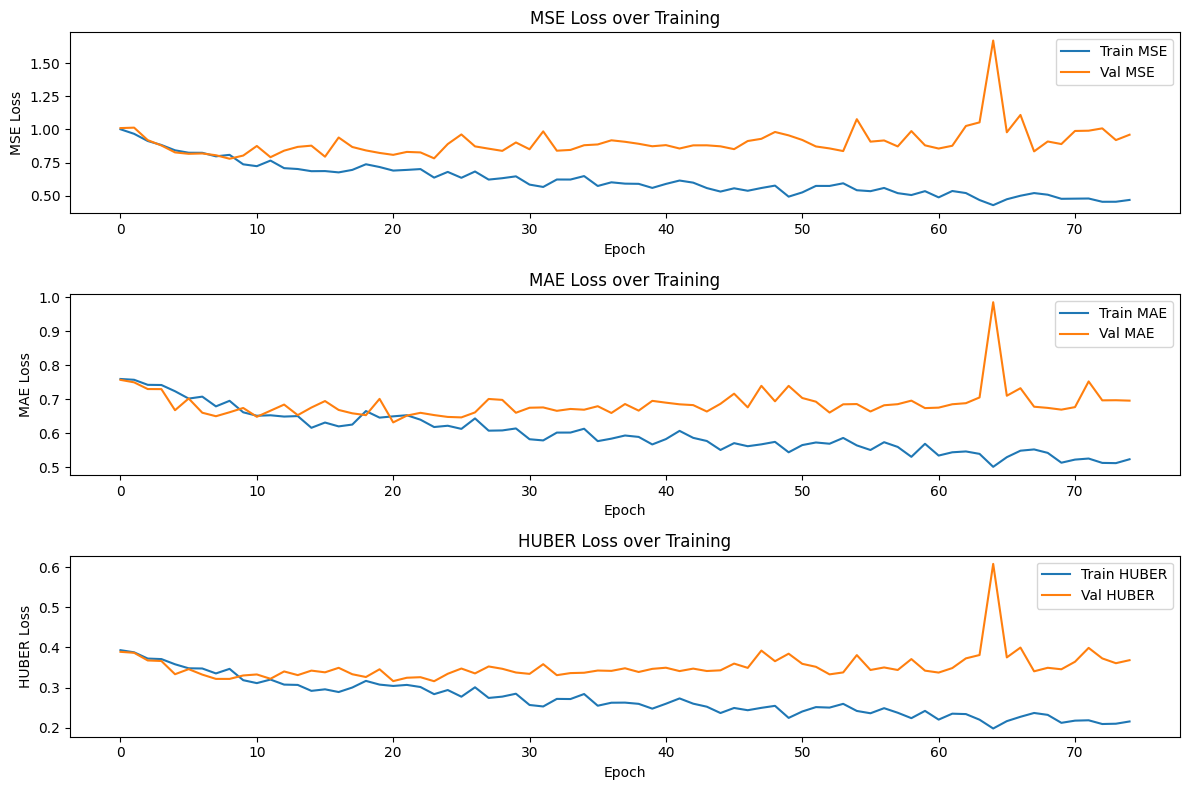

In [25]:

# Plot losses for each metric
plt.figure(figsize=(12, 8))

for i, (name, losses) in enumerate(train_losses.items()):
    plt.subplot(len(train_losses), 1, i+1)
    plt.plot(losses, label=f'Train {name.upper()}')
    plt.plot(val_losses[name], label=f'Val {name.upper()}')
    plt.xlabel("Epoch")
    plt.ylabel(f"{name.upper()} Loss")
    plt.legend()
    plt.title(f"{name.upper()} Loss over Training")

plt.tight_layout()
plt.show()





#### 7) Plot Training and Validation Loss







#### 8) Evaluation on Test Set and Additional Metrics




In [26]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        # Detach and move to CPU; flatten the predictions.
        preds = outputs.cpu().numpy().flatten()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute Spearman's rank correlation coefficient (SROCC)
spearman_corr, _ = spearmanr(all_labels, all_preds)

# Compute Mean Absolute Error (MAE)
mae_val = mean_absolute_error(all_labels, all_preds)

# Compute Pearson correlation coefficient
pearson_corr, _ = pearsonr(all_labels, all_preds)
# Compute R² score
r2_val = r2_score(all_labels, all_preds)

print(f"SROCC:    {spearman_corr:.4f}")
print(f"Pearson:  {pearson_corr:.4f}")
print(f"R^2:      {r2_val:.4f}")
print(f"MAE: {mae_val:.4f}")




SROCC:    0.6054
Pearson:  0.6579
R^2:      0.3411
MAE: 0.5431


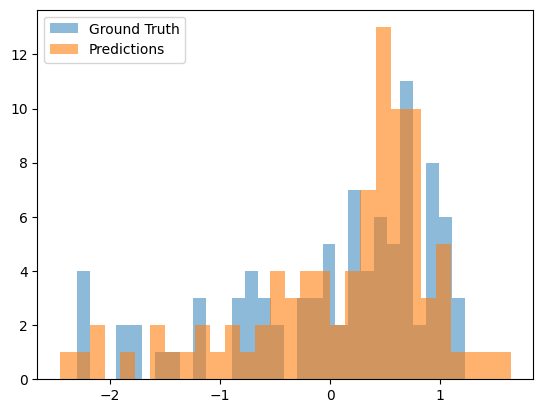

In [27]:
import matplotlib.pyplot as plt

plt.hist(all_labels, bins=30, alpha=0.5, label='Ground Truth')
plt.hist(all_preds, bins=30, alpha=0.6, label='Predictions')
plt.legend()
plt.show()


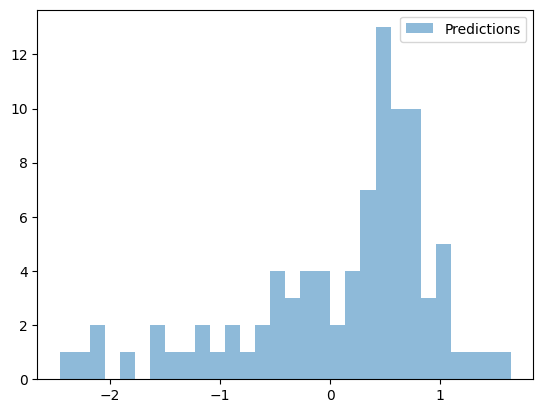

In [28]:
import matplotlib.pyplot as plt

plt.hist(all_preds, bins=30, alpha=0.5, label='Predictions')
plt.legend()
plt.show()


Scatter Plot: Good for a quick check of overall agreement.

Residual Plot: Reveals any patterns or heteroscedasticity in your errors.

Histogram/Density of Residuals: Helps to understand the error distribution.




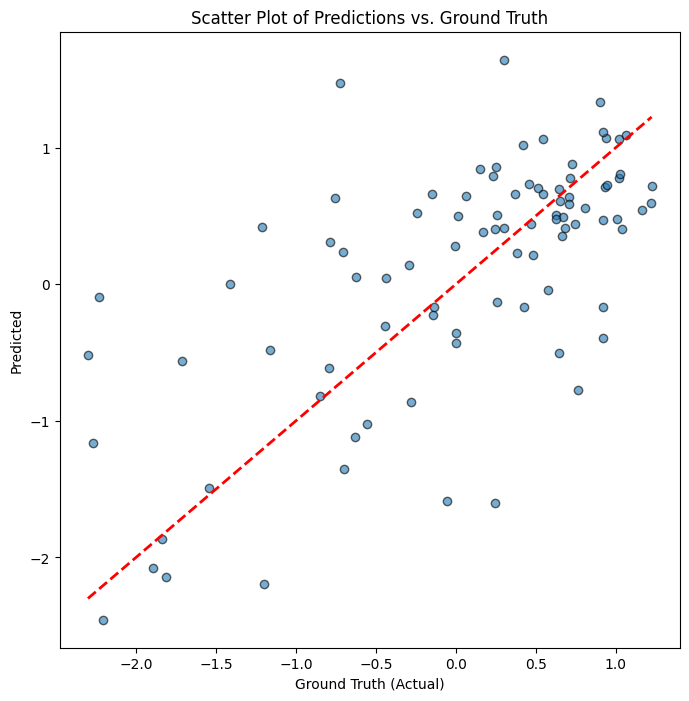

In [29]:
plt.figure(figsize=(8, 8))
plt.scatter(all_labels, all_preds, alpha=0.6, edgecolors='k')
plt.plot([all_labels.min(), all_labels.max()], [all_labels.min(), all_labels.max()], 'r--', lw=2)
plt.xlabel('Ground Truth (Actual)')
plt.ylabel('Predicted')
plt.title('Scatter Plot of Predictions vs. Ground Truth')
plt.show()


This plot displays the residuals (i.e., the difference between the ground truth and the predictions) against either the predicted values or the true values. It helps to diagnose patterns in the errors (e.g., heteroscedasticity or non-linearity).


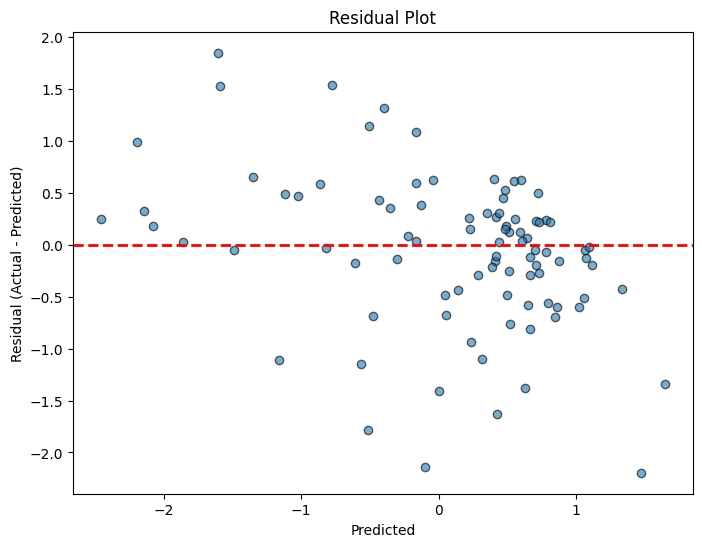

In [30]:
residuals = all_labels - all_preds

plt.figure(figsize=(8, 6))
plt.scatter(all_preds, residuals, alpha=0.6, edgecolors='k')
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residual Plot')
plt.show()


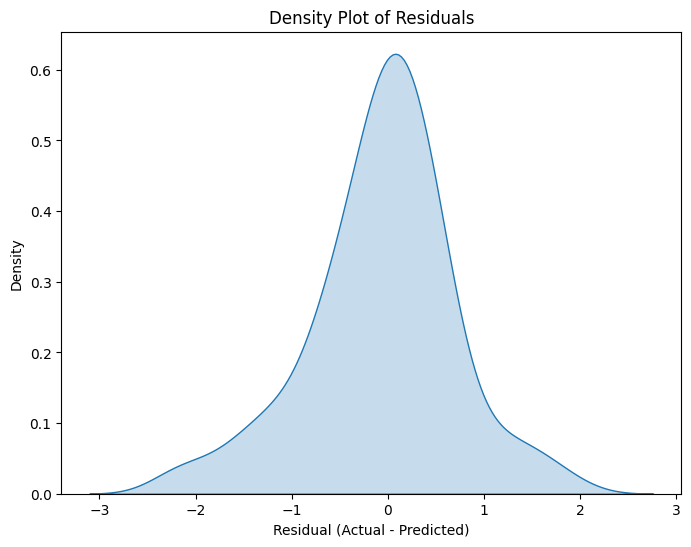

In [31]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.kdeplot(residuals, fill=True)
plt.xlabel('Residual (Actual - Predicted)')
plt.title('Density Plot of Residuals')
plt.show()


In [32]:

#############################################
# 9) Optional: Print a few predictions vs. ground truth
#############################################
# print("\nSome sample predictions:")
# for i in range(min(5, len(all_preds))):
#     print(f"Predicted (z-score normalized MOS): {all_preds[i]:.3f} | Actual (z-score normalized MOS): {all_labels[i]:.3f}")

# (Optional) If you need to convert the z-score normalized MOS back to the original scale:
def denormalize_mos(z_score_mos):
    return z_score_mos * mos_std + mos_mean

print("\nSome sample predictions (original MOS scale):")
for i in range(min(5, len(all_preds))):
    pred_orig = denormalize_mos(all_preds[i])
    actual_orig = denormalize_mos(all_labels[i])
    print(f"Predicted: {pred_orig:.3f} | Actual: {actual_orig:.3f}")



Some sample predictions (original MOS scale):
Predicted: 71.206 | Actual: 75.843
Predicted: 75.127 | Actual: 76.324
Predicted: 76.508 | Actual: 85.236
Predicted: 71.298 | Actual: 42.999
Predicted: 40.598 | Actual: 51.926


In [33]:
# Save only the model weights (state_dict)
# torch.save(model.state_dict(), '../weights/torch/best_model_weights_base_cnn_correct_zscore_updates.pth')


In [34]:
# Save only the model weights (state_dict)
import datetime

# Format: YYYY-MM-DD_HH-MM-SS
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_time_%H-%M-%S")
print(f"Current timestamp for filename: {timestamp}")

model_name = 'baseCNN'

torch.save(model.state_dict(), f'./weights/torch/{model_name}_{timestamp}_SROCC_{int(spearman_corr*100)}_Pearson_{int(pearson_corr*100)}.pth')


Current timestamp for filename: 2025-05-06_time_08-33-32


In [35]:
all_labels * mos_std + mos_mean


array([75.843124, 76.32376 , 85.23632 , 42.999252, 51.925537, 43.14833 ,
       71.977554, 72.89617 , 50.39706 , 66.6477  , 68.466644, 61.55745 ,
       79.68298 , 81.65584 , 50.287716, 75.24948 , 84.18152 , 80.298065,
       53.155952, 24.706413, 81.70711 , 75.142426, 70.47334 , 82.0784  ,
       71.255455, 70.61026 , 73.448746, 79.91532 , 76.92114 , 64.2537  ,
       65.12859 , 32.572605, 76.35414 , 59.82249 , 72.32991 , 68.402565,
       74.89747 , 63.997463, 68.26595 , 53.111687, 71.36296 , 68.02868 ,
       76.58064 , 64.02835 , 72.1626  , 51.789093, 81.78998 , 75.21942 ,
       73.44619 , 49.269928, 79.92257 , 31.113838, 25.27229 , 77.97334 ,
       80.18475 , 56.34353 , 50.95214 , 81.49191 , 25.73949 , 79.94758 ,
       76.28997 , 66.92138 , 74.053024, 82.50789 , 63.924187, 80.4484  ,
       75.62667 , 39.503628, 54.35688 , 68.27114 , 63.033073, 75.48288 ,
       79.97019 , 61.448536, 69.23367 , 59.15176 , 56.418743, 34.254765,
       85.12217 , 58.92814 , 24.108433, 61.660263, 

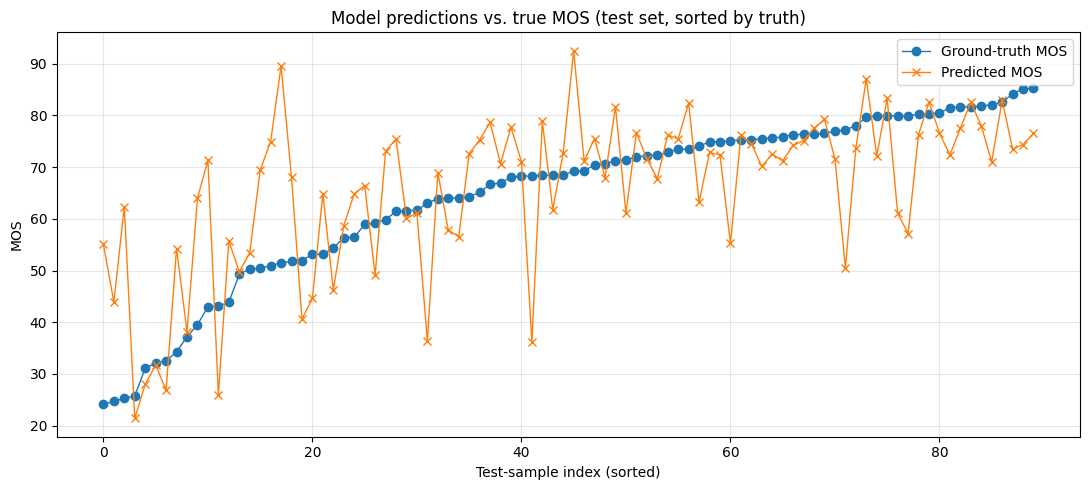

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1) Go back to the ORIGINAL MOS scale -----------------------
pred_orig   = denormalize_mos(all_preds)   # ← fn you already defined
actual_orig = denormalize_mos(all_labels)

# --- 2) Sort by the true MOS so the plot is easier to read ------
order = np.argsort(actual_orig)            # indices that sort ground‑truth
truth_sorted = actual_orig[order]
pred_sorted  = pred_orig[order]

# --- 3) Line plot -----------------------------------------------
plt.figure(figsize=(11, 5))
plt.plot(truth_sorted, label='Ground-truth MOS',  marker='o', lw=1)
plt.plot(pred_sorted,  label='Predicted MOS',    marker='x', lw=1)

plt.title('Model predictions vs. true MOS (test set, sorted by truth)')
plt.xlabel('Test-sample index (sorted)')
plt.ylabel('MOS')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
